In [8]:
import sys
sys.path.append('../../..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from sklearn import preprocessing
from utils.evaluate import calculate_ctr, compute_rce, average_precision_score
from sklearn.model_selection import train_test_split
from utils.dataset import Dataset


from utils.preprocessing import *
import core.config as conf

## Load data 

In [9]:
train_data_path = conf.dataset_path + 'part-210204-2'
train_df = read_data(train_data_path)

In [10]:
train_df.head()

,text_tokens,hashtags,tweet_id,media,links,domains,tweet_type,language,tweet_timestamp,creator_id,...,engager_id,engager_follower_count,engager_following_count,engager_is_verified,engager_account_creation,creator_follows_engager,reply_timestamp,retweet_timestamp,comment_timestamp,like_timestamp
0,101\t56898\t137\t146\t92317\t80092\t10341\t101...,43A368EE393CD9AFD640D8E9D97F9117\tF7DAF7DDB9A9...,A7EAACD487F59B850B49F6F694261887,Video,NaN,NaN,Retweet,488B32D24BD4BB44172EB981C1BCA6FA,1612451187,375D72BD560D848C2D5425130DD35CD2,...,9F191E0EF45CC3491FC7AD1C29D203B9,128,450,False,1425269499,True,NaN,1.612454e+09,NaN,1.612454e+09
1,101\t14120\t131\t120\t120\t188\t119\t11170\t12...,NaN,9F128BDCF151A483EF11EB319473BE44,Photo\tPhoto,NaN,NaN,TopLevel,313ECD3A1E5BB07406E4249475C2D6D6,1612443885,C02B819378BD51A39B6341E4017FF481,...,82FBB3B5150270FBFC4AC0EAAA6A541E,10,646,False,1544363412,False,NaN,NaN,NaN,NaN
2,101\t56898\t137\t147\t92161\t32792\t44026\t381...,NaN,F8AB716F01EF3B2E3D07A62A30347B5C,NaN,NaN,NaN,Retweet,9FCF19233EAD65EA6E32C2E6DC03A444,1612427814,E68E0C6533173D179FF4E867027AF68D,...,04FCA727D001288BAD09B48C80EC4F77,132,226,False,1549597072,False,NaN,1.612428e+09,NaN,NaN
3,101\t10117\t108\t10339\t20799\t10943\t60036\t1...,0ED93216A8842FECE9F5ADA917FC159A,784A93DE671CA4D15286A09C8124C6AB,Photo\tPhoto\tPhoto\tPhoto,NaN,NaN,TopLevel,488B32D24BD4BB44172EB981C1BCA6FA,1612412744,9C7E5A54E672CC8278B25F1FBF4F910B,...,181F3FE296817603354FF850B885EEF8,75,193,False,1570785840,False,NaN,NaN,NaN,1.612417e+09
4,101\t56898\t137\t19556\t10237\t11355\t19986\t1...,NaN,D0C06B49E844FBD9C64F938759A2E5FF,NaN,NaN,NaN,Retweet,488B32D24BD4BB44172EB981C1BCA6FA,1612482791,EC601AB42FE914EDE8EC092714AAE38B,...,72063E9607EE7B14CCB24CBCF0B1FE90,958,196,False,1585271012,True,NaN,NaN,NaN,NaN


In [11]:
val_data_path = conf.dataset_path + 'part-210205-2'
val_df = read_data(val_data_path)

In [12]:
train_df.columns

Index(['text_tokens', 'hashtags', 'tweet_id', 'media', 'links', 'domains',
       'tweet_type', 'language', 'tweet_timestamp', 'creator_id',
       'creator_follower_count', 'creator_following_count',
       'creator_is_verified', 'creator_account_creation', 'engager_id',
       'engager_follower_count', 'engager_following_count',
       'engager_is_verified', 'engager_account_creation',
       'creator_follows_engager', 'reply_timestamp', 'retweet_timestamp',
       'comment_timestamp', 'like_timestamp'],
      dtype='object')

## Parameters

In [13]:
MODEL_NAME = 'autoencoder_test'
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCH = 30
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1 

## Preprocessing

### dataset preprocess

In [15]:
ds = Dataset(train=True, target_encoding=False)
train_df = ds.preprocess(train_df)
val_df = ds.preprocess(val_df)

### negative samping

In [17]:
train_df_positive = train_df[train_df['like']==1]
train_df_negative = train_df[train_df['like']==0]
print(len(train_df_positive))
print(len(train_df_negative))

train_df_positive = train_df_positive.sample(n = len(train_df_negative))
train_df_negative = train_df_negative.sample(n = len(train_df_positive))
train_df = pd.concat([train_df_positive, train_df_negative])

3522117
3522117


In [22]:
train_df.head()

,creator_follower_count,media,creator_following_count,engager_follower_count,creator_id,tweet_type,engager_id,engager_is_verified,creator_follows_engager,tweet_timestamp,...,creator_is_verified,language,reply,retweet,comment,like,dt_day,dt_dow,dt_hour,len_domains
2729889,339,9,334,1542,CBC6939677FAF0D1231AB4641B06869D,2,EFDE91C119FDA263F2785C0A13772DB2,0,1,1612440067,...,0,19,0.0,0.0,0.0,1.0,4,3,12,0
7695415,4933,0,3468,8,E9C9A7632EAC6E3FA3374F45064BE80A,1,D5430B3F39025A0BEC4948F12AB2836C,0,0,1612415200,...,0,19,0.0,0.0,0.0,1.0,4,3,5,0
1793599,22628,5,357,255,02E7DD47A0223EB26FA0E4B13A4ACC84,2,26AFC4E0C59BEE0483A0A132B8F9D17B,0,0,1612449813,...,0,19,0.0,0.0,0.0,1.0,4,3,14,0
9022062,43588,0,1089,264,774DB6D0B20AB9AB498030D8386CFF10,2,55311D4A7E7CCA0D29C0358C753E2C83,0,0,1612425724,...,0,41,0.0,0.0,0.0,1.0,4,3,8,0
1136448,60,7,71,53,9E3D6450D1F1E656ACF77B97794162D6,2,2F463D93E8E36DBF50905663D0EC9E14,0,1,1612432362,...,0,61,0.0,0.0,0.0,1.0,4,3,9,0


In [20]:
train_df.columns

Index(['creator_follower_count', 'media', 'creator_following_count',
       'engager_follower_count', 'creator_id', 'tweet_type', 'engager_id',
       'engager_is_verified', 'creator_follows_engager', 'tweet_timestamp',
       'creator_account_creation', 'domains', 'tweet_id',
       'engager_following_count', 'engager_account_creation',
       'creator_is_verified', 'language', 'reply', 'retweet', 'comment',
       'like', 'dt_day', 'dt_dow', 'dt_hour', 'len_domains'],
      dtype='object')

In [21]:
conf.target

['reply', 'retweet', 'comment', 'like']

In [24]:
used_features = ['engager_follower_count', 
                'engager_following_count', 
                'engager_is_verified', 
                'engager_account_creation', 
                'creator_follower_count', 
                'creator_following_count', 
                'creator_is_verified', 
                'creator_account_creation',
                'media',
                'domains',
                'language',
                'dt_day', 
                'dt_dow', 
                'dt_hour', 
                'len_domains']

In [55]:
X_train = train_df[used_features]
# Y_train = train_df['like_timestamp'].fillna(0).apply(lambda x: 1 if x > 0 else 0)
Y_train = train_df['like']

In [54]:
X_val = val_df[used_features]
# Y_val = val_df['like_timestamp'].fillna(0).apply(lambda x: 1 if x > 0 else 0) 
Y_val = val_df['like']

In [58]:
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5)


### scaling


In [59]:
def scaling(df_x):
    standard_scaler = preprocessing.StandardScaler()
    standard_scaler.fit(df_x.values)
    ss = standard_scaler.transform(df_x.values)
    df_x = pd.DataFrame(ss, columns = df_x.columns)
    return df_x

In [60]:
X_train = scaling(X_train)
X_val = scaling(X_val)
X_test = scaling(X_test)

In [61]:
X_train

,engager_follower_count,engager_following_count,engager_is_verified,engager_account_creation,creator_follower_count,creator_following_count,creator_is_verified,creator_account_creation,media,domains,language,dt_day,dt_dow,dt_hour,len_domains
0,0.065438,0.250054,-0.042751,1.117690,-0.160558,-0.104612,-0.485825,1.302187,2.083948,-0.137477,-0.701192,0.0,0.0,-0.001614,-0.335
1,-0.072417,-0.382735,-0.042751,-0.321297,-0.159629,-0.021338,-0.485825,0.353989,-0.751913,-0.137477,-0.701192,0.0,0.0,-1.024722,-0.335
2,-0.050220,-0.327063,-0.042751,-1.789442,-0.156054,-0.104001,-0.485825,-1.602844,0.823566,-0.137477,-0.701192,0.0,0.0,0.290702,-0.335
3,-0.049411,-0.243830,-0.042751,0.409202,-0.151818,-0.084551,-0.485825,-0.900066,-0.751913,-0.137477,0.476125,0.0,0.0,-0.586247,-0.335
4,-0.068373,-0.370609,-0.042751,1.088461,-0.160614,-0.111601,-0.485825,1.236772,1.453757,-0.137477,1.546412,0.0,0.0,-0.440089,-0.335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044229,-0.072058,-0.306668,-0.042751,0.864684,-0.158436,-0.113115,-0.485825,1.243058,0.823566,-0.137477,-1.236336,0.0,0.0,0.290702,-0.335
7044230,-0.070799,-0.285171,-0.042751,0.683346,-0.137245,-0.112876,-0.485825,0.995523,0.823566,-0.137477,-1.182822,0.0,0.0,-1.463197,-0.335
7044231,-0.059027,-0.165559,-0.042751,-0.300933,-0.160384,-0.102752,-0.485825,0.083358,-0.436817,-0.137477,-0.701192,0.0,0.0,-1.024722,-0.335
7044232,-0.056511,-0.376121,-0.042751,0.491265,-0.160368,-0.090078,-0.485825,-1.484033,0.823566,-0.137477,-0.701192,0.0,0.0,0.729177,-0.335


## Model

### Encoder Layer

In [62]:

kargs = {
    'model_name': 'auto_encoder',
    'input_dim' : X_train.shape[1],
    'engager_dim' : 4,
    'creator_dim' : 4,
    'embedding_dim': 32,
    'encoder_dim': 64,
    'decoder_dim': 1
    
}


In [63]:
class AutoEncoder(tf.keras.models.Model):
    def __init__(self, **kargs):
        super(AutoEncoder, self).__init__()
        
        self.input_dim = kargs['input_dim']
        self.engager_dim = kargs['engager_dim']
        self.creator_dim = kargs['creator_dim']
        self.embedding_dim = kargs['embedding_dim']
        self.encoder_dim = kargs['encoder_dim']
        self.decoder_dim = kargs['decoder_dim']
        
        # self.engager_embedding = tf.keras.layers.Embedding(input_dim=self.engager_dim, output_dim=self.embedding_dim)
        # self.creator_embedding = tf.keras.layers.Embedding(input_dim=self.creator_dim, output_dim=self.embedding_dim)
    
        self.engager_encoder = tf.keras.layers.Dense(16, activation = 'relu')
        self.creator_encoder = tf.keras.layers.Dense(16, activation = 'relu')
        self.tweet_encoder = tf.keras.layers.Dense(16, activation = 'relu')
        self.encoder1 = tf.keras.layers.Dense(8, activation = 'relu')
        self.encoder2 = tf.keras.layers.Dense(4, activation = 'relu')
        self.decoder = tf.keras.layers.Dense(1, activation = 'relu')
    
    def call(self, x):
        # x1 = self.engager_embedding(x[:,:4])
        # x2 = self.creator_embedding(x[:,4:])
        # input1 = tf.dtypes.cast(x[:, :4], tf.float32) 
        # input2 = tf.dtypes.cast(x[:, 4:], tf.float32) 
        # x = tf.concat([x1, x2], 1)
        x1 = self.engager_encoder(x[:,:4])
        x2 = self.creator_encoder(x[:,4:8])
        x3 = self.tweet_encoder(x[:,8:])
        x = tf.concat([x1, x2], 1)
        x = self.encoder1(x)
        x = tf.concat([x, x3], 1)
        x = self.encoder2(x)
        x = self.decoder(x)
        return x

    def summary(self):
        inputs = tf.keras.layers.Input((self.input_dim))
        tf.keras.models.Model(inputs, self.call(inputs)).summary()
    

In [64]:
model = AutoEncoder(**kargs)


In [65]:
model.summary()
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy', # softmax : sparse_categorical_crossentropy, sigmoid : binary_crossentropy
    metrics=['binary_crossentropy', 'accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, 4)            0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_4 (Sli (None, 4)            0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 16)           80          tf.__operators__.getitem_3[0][0] 
____________________________________________________________________________________________

In [36]:
result = model.fit(
    x = X_train.to_numpy(),
    y = Y_train.to_numpy(),
    validation_data=(X_val.to_numpy(), Y_val.to_numpy()),
    epochs=10,
    batch_size=32
)

Epoch 1/5
55034/55034 [==============================] - 33s 596us/step - loss: 0.6944 - binary_crossentropy: 0.6944 - accuracy: 0.5623 - val_loss: 0.6769 - val_binary_crossentropy: 0.6769 - val_accuracy: 0.5489
Epoch 2/5
55034/55034 [==============================] - 32s 588us/step - loss: 0.6716 - binary_crossentropy: 0.6716 - accuracy: 0.5780 - val_loss: 0.6770 - val_binary_crossentropy: 0.6770 - val_accuracy: 0.5512
Epoch 3/5
55034/55034 [==============================] - 32s 589us/step - loss: 0.6706 - binary_crossentropy: 0.6706 - accuracy: 0.5805 - val_loss: 0.6742 - val_binary_crossentropy: 0.6742 - val_accuracy: 0.5636
Epoch 4/5
55034/55034 [==============================] - 32s 587us/step - loss: 0.6703 - binary_crossentropy: 0.6703 - accuracy: 0.5808 - val_loss: 0.6736 - val_binary_crossentropy: 0.6736 - val_accuracy: 0.5682
Epoch 5/5
55034/55034 [==============================] - 33s 592us/step - loss: 0.6692 - binary_crossentropy: 0.6692 - accuracy: 0.5829 - val_loss: 0.66

## Evaluate

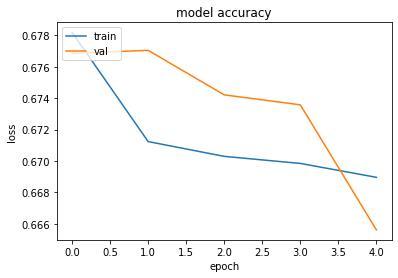

In [37]:
plt.plot(result.history['binary_crossentropy'])
plt.plot(result.history['val_binary_crossentropy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [38]:
pred = model.predict(X_test)

In [39]:
pred.reshape(-1)

array([0.5074967 , 0.51459104, 0.56019574, ..., 0.37304753, 0.55572414,
       0.37603962], dtype=float32)

In [46]:
pred, Y_test

(array([[0.5074967 ],
        [0.51459104],
        [0.56019574],
        ...,
        [0.37304753],
        [0.55572414],
        [0.37603962]], dtype=float32),
          like
 5442468   1.0
 1475424   0.0
 7563845   1.0
 1790141   0.0
 56857     1.0
 ...       ...
 4454309   0.0
 6365802   1.0
 7950770   0.0
 8662216   0.0
 8597333   0.0
 
 [4343097 rows x 1 columns])

In [51]:
Y_test['like'].astype(np.float64)

5442468    1.0
1475424    0.0
7563845    1.0
1790141    0.0
56857      1.0
          ... 
4454309    0.0
6365802    1.0
7950770    0.0
8662216    0.0
8597333    0.0
Name: like, Length: 4343097, dtype: float64

In [53]:
rce = compute_rce(pred.astype(np.float64), Y_test['like'].astype(np.float64))
rce

0.7514130577736422

In [44]:
average_precision_score(Y_test, pred)

0.4858346180148363